# This notebook's goal is to detect fraud in credit card transactions using a Kaggle dataset.

In [1]:
import pandas as pd
import numpy as np
from MyML import *

In [2]:
data = pd.read_csv('creditcard.csv').values

In [3]:
def TVTsplit(matrix, train = .7):
    #     This function's purpose is to split a given matrix
    #     into three parts: train, test, and validate. The 
    #     train parameter is the percentage of the data that
    #     goes into training 70% by default. The val parameter
    #     determines how much goes into the validation set
    #     15% by default. The rest of the data goes into
    #     the test set.
    
#     The following is needed to perform the operations
#     in the calculations in here.
    import numpy as np
    # The following does some common sense things like
    # telling you that train and val need to add up to less
    # than 1.

    if(train > .99):
        print("Splitting failed. Please make sure that train is less than .99 so that test and val have enough data.")
        return 0
    
#     These two things calculate the subset lengths that 
#     are needed for the subsetting.
    splitnum = int(len(matrix[:,0])*train)
    splitnum2 = int((len(matrix[:,0]) - splitnum)/2)
#     np.random.shuffle(matrix)

#     The next three separate the data into the three sets
#     using the splitnums from above.
    Train = matrix[0:splitnum,]
    Test = matrix[splitnum:(splitnum+splitnum2),]
    Val = matrix[(splitnum+splitnum2):,]
    return Train, Val, Test

In [4]:
train, val, test = TVTsplit(data)

In [5]:
Xtrain = train[:,:-1]
Ytrain = train[:,-1].reshape(-1,1)
Xval = val[:,:-1]
Yval = val[:,-1].reshape(-1,1)
Xtest = test[:,:-1]
Ytest = test[:,-1].reshape(-1,1)

In [6]:
mins = np.min(Xtrain, axis = 0)
maxs = np.max(Xtrain, axis = 0)

In [7]:
Xtrain = (Xtrain - mins)/(maxs - mins)
Xval = (Xval - mins)/(maxs - mins)
Xtest = (Xtest - mins)/(maxs - mins)

In [8]:
Xtrainnot = Xtrain[np.where(Ytrain == 0)[0],]
Ytrainnot = Ytrain[np.where(Ytrain == 0)[0],]
Xtrainfraud = Xtrain[np.where(Ytrain == 1)[0],]
Ytrainfraud = Ytrain[np.where(Ytrain == 1)[0],]

# The following trains 20 neural networks so that I can ensemble them together.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


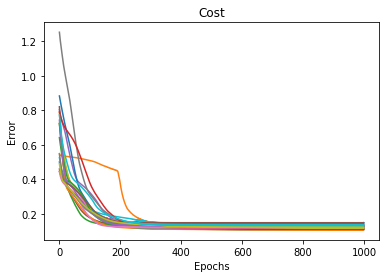

In [91]:
models = {}
errs = []
for i in range(20):
    print(i)
    choicenot = np.random.choice(list(range(len(Xtrainnot))),size = 3000,replace = True)
    Xtrain1 = Xtrainnot[choicenot,]
    Ytrain1 = Ytrainnot[choicenot,]
    choicefraud = np.random.choice(list(range(len(Xtrainfraud))),size = 500,replace = True)
    Xtrain2 = Xtrainfraud[choicefraud,]
    Ytrain2 = Ytrainfraud[choicefraud,]
    newX = np.row_stack((Xtrain1,Xtrain2))
    newY = np.row_stack((Ytrain1,Ytrain2))
    model = NeuralNetwork(indims = Xtrain.shape[1], nodes = [20,20,20,1], activations = ['relu','relu','relu'], taskType = 'c')
    model.train(newX,newY, optim = 'adam', lr = .001, epochs = 1000)
    models[str(i)] = model

In [142]:
trainpredictions = np.empty((len(Xtrain),20))
valpredictions = np.empty((len(Xval),20))
testpredictions = np.empty((len(Xtest), 20))
for i in range(20):
    models[str(i)].predict(Xtrain,p = 1)
    trainpredictions[:,i] = models[str(i)].prediction.T[0].tolist()
    models[str(i)].predict(Xval,p = 1)
    valpredictions[:,i] = models[str(i)].prediction.T[0].tolist()
    models[str(i)].predict(Xtest,p = 1)
    testpredictions[:,i] = models[str(i)].prediction.T[0].tolist()

In [135]:
ensemble = NeuralNetwork(indims = 20, nodes = [10,10,10,1], activations = ['relu','relu','relu'])

In [136]:
ensemble.train(trainpredictions,Ytrain,valpredictions,Yval, optim = 'adam', lr = .001, epochs = 1000)

KeyboardInterrupt: 

In [138]:
np.sum(ensemble.prediction*Yval)

29.0

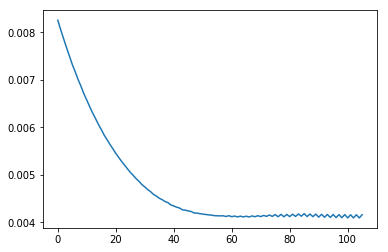

In [141]:
plt.plot(ensemble.errs[300:])

In [144]:
ensemble.predict(testpredictions, p = 1)

array([[0.00033729],
       [0.00033729],
       [0.00033729],
       ...,
       [0.00033729],
       [0.00033729],
       [0.00033729]])

# The following code is the functions required to make a decision tree from scratch.

In [151]:
def gini(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini
def test_split(index, value, data):
    r = np.array(data[:,index]<value, dtype = int)
    left = data[np.where(r == 1)[0],]
    right = data[np.where(r == 0)[0],]
    return left, right
def getsplit(data):
    labels = np.unique(data[:,-1])
    bestind, bestval, bestscore, bestgroup = 999,999,999, None
    for i in range(data.shape[1]-1):
        for j in range(data.shape[0]):
            groups = test_split(i, data[j,i],data)
            score = gini(groups, labels)
            if score < bestscore:
                bestind, bestval, bestscore, bestgroup = i, data[j,i], score, groups
    return {'index':bestind,'value':bestval,'groups':bestgroup}
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)
def split(node, maxdepth,minsize,depth):
    left, right  = node['groups']
    del(node['groups'])
    if len(left) == 0:
        node['left'] = node['right'] = to_terminal(right)
        return
    if len(right) == 0:
        node['left'] = node['right'] = to_terminal(left)
        return
    if depth >= maxdepth:
        node['left'], node['right'] = to_terminal(left),to_terminal(right)
        return
    if len(left) <= minsize:
        node['left'] = to_terminal(left)
    else:
        node['left'] = getsplit(left)
        split(node['left'], maxdepth, minsize,depth+1)
    if len(right) <= minsize:
        node['right'] = to_terminal(right)
    else:
        node['right'] = getsplit(right)
        split(node['right'], maxdepth, minsize,depth+1)
def buildtree(x, maxdepth, minsize):
    root = getsplit(x)
    split(root, maxdepth,minsize, 1)
    return root
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [150]:
trees = {}
errs = []
for i in range(20):
    print(i)
    choicenot = np.random.choice(list(range(len(Xtrainnot))),size = 3000,replace = True)
    Xtrain1 = Xtrainnot[choicenot,]
    Ytrain1 = Ytrainnot[choicenot,]
    choicefraud = np.random.choice(list(range(len(Xtrainfraud))),size = 500,replace = True)
    Xtrain2 = Xtrainfraud[choicefraud,]
    Ytrain2 = Ytrainfraud[choicefraud,]
    newX = np.row_stack((Xtrain1,Xtrain2))
    newY = np.row_stack((Ytrain1,Ytrain2))
    new = np.column_stack((newX,newY))
    tree = buildtree(new, 3,3)
    trees[str(i)] = tree

0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [176]:
treetrainpredictions = np.empty((len(Xtrain),8))
treevalpredictions = np.empty((len(Xval),8))
treetestpredictions = np.empty((len(Xtest), 8))
for i in range(8):
    trainpreds = []
    for j in range(len(Xtrain)):
        trainpreds.append(predict(trees[str(i)],train[j,]))
    treetrainpredictions[:,i] = trainpreds
    valpreds = []
    for j in range(len(Xval)):
        valpreds.append(predict(trees[str(i)],val[j,]))
    treevalpredictions[:,i] = valpreds
    testpreds = []
    for j in range(len(Xtest)):
        testpreds.append(predict(trees[str(i)],test[j,]))
    treetestpredictions[:,i] = testpreds

In [195]:
treeensemble = NeuralNetwork(indims = 8, nodes = [12,12,12,1], activations = ['relu','relu','relu'], taskType = 'c')

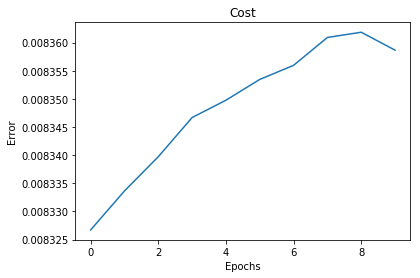

In [206]:
treeensemble.train(treetrainpredictions, Ytrain, treevalpredictions, Yval, optim = 'adam',lr = .0001)

In [207]:
treeensemble.predict(treevalpredictions, p = 1)

array([[0.00027496],
       [0.0001876 ],
       [0.0001876 ],
       ...,
       [0.00139389],
       [0.00276315],
       [0.00276315]])

In [208]:
np.sum(treeensemble.prediction)

0.0

# The following unleashes one of the most powerful algorithms known to man. XGBoost.

In [211]:
!pip install xgboost

    100% |████████████████████████████████| 114.0MB 437kB/s ta 0:00:011


In [9]:
import xgboost as xgb

In [71]:
dtrain = xgb.DMatrix(Xtrain, label = Ytrain)
param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
dval = xgb.DMatrix(Xval, label = Yval)
evallist = [(dtrain,'train'),(dval,'eval')]

In [72]:
num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.915205	eval-auc:0.836413
[1]	train-auc:0.928344	eval-auc:0.855681
[2]	train-auc:0.929535	eval-auc:0.865201
[3]	train-auc:0.953869	eval-auc:0.897022
[4]	train-auc:0.960619	eval-auc:0.90712
[5]	train-auc:0.970711	eval-auc:0.946556
[6]	train-auc:0.987805	eval-auc:0.982655
[7]	train-auc:0.991089	eval-auc:0.980403
[8]	train-auc:0.993033	eval-auc:0.966906
[9]	train-auc:0.996296	eval-auc:0.960738
[10]	train-auc:0.997247	eval-auc:0.958953
[11]	train-auc:0.998046	eval-auc:0.965291
[12]	train-auc:0.998148	eval-auc:0.962698
[13]	train-auc:0.998313	eval-auc:0.958907
[14]	train-auc:0.998734	eval-auc:0.960268
[15]	train-auc:0.998916	eval-auc:0.965464
[16]	train-auc:0.99895	eval-auc:0.968288
[17]	train-auc:0.999373	eval-auc:0.959806
[18]	train-auc:0.999655	eval-auc:0.961536
[19]	train-auc:0.999758	eval-auc:0.966906


In [9]:
xgbtrainpred = np.round(bst.predict(dtrain)).reshape(-1,1)
xgbvalpred = np.round(bst.predict(dval)).reshape(-1,1)
dtest = xgb.DMatrix(Xtest,label = Ytest)
xgbtestpred = np.round(bst.predict(dtest)).reshape(-1,1)


In [10]:
np.sum(Xtrain[np.where(xgbtestpred == 1)[0],], axis = 0)

array([ 1.11116500e+06, -2.40255158e-01,  1.12234303e+01,  2.68857792e+01,
        1.26156239e+01, -9.83603355e+00, -1.60816834e-01,  2.36155092e+00,
        2.28524645e+00,  7.39684408e+00,  1.81466658e+00,  3.00326439e+01,
       -9.13392430e+00,  8.57854419e+00,  5.58241321e+00,  1.03004083e+01,
       -6.78086992e+00,  1.31036743e+01, -9.80730333e-01,  1.25972005e+00,
        4.16322184e+00, -3.14470622e+00, -9.59593679e+00,  1.55896657e+00,
       -2.53319043e+00,  2.06319602e+00,  1.40369685e-01,  1.38710839e+00,
       -2.83783788e-01,  2.87518000e+03])

In [11]:
2.875*10**3

2875.0

In [225]:
tottrainpreds = np.column_stack((trainpredictions,xgbtrainpred))
totvalpreds = np.column_stack((valpredictions, xgbvalpred))
tottestpreds = np.column_stack((testpredictions, xgbtestpred))

In [251]:
totensemble = NeuralNetwork(indims = 21, nodes = [20,20,20,20,1], activations = ['relu','relu','relu','relu'])

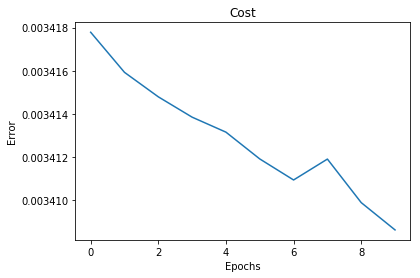

In [266]:
totensemble.train(tottrainpreds, Ytrain, totvalpreds, Yval, optim = 'adam', lr = .0001)

# The following makes 20 XGBoost models so I can ensemble those together.

In [19]:
models = {}
errs = []
for i in range(20):
    print(i)
    choicenot = np.random.choice(list(range(len(Xtrainnot))),size = 3000,replace = True)
    Xtrain1 = Xtrainnot[choicenot,]
    Ytrain1 = Ytrainnot[choicenot,]
    choicefraud = np.random.choice(list(range(len(Xtrainfraud))),size = 500,replace = True)
    Xtrain2 = Xtrainfraud[choicefraud,]
    Ytrain2 = Ytrainfraud[choicefraud,]
    newX = np.row_stack((Xtrain1,Xtrain2))
    newY = np.row_stack((Ytrain1,Ytrain2))
    dtrain = xgb.DMatrix(newX, label = newY)
    param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    dval = xgb.DMatrix(Xval, label = Yval)
    evallist = [(dtrain,'train'),(dval,'eval')]
    num_round = 8
    bst = xgb.train(param, dtrain, num_round, evallist)
    models[str(i)] = bst

0
[0]	train-auc:0.957911	eval-auc:0.907129
[1]	train-auc:0.969838	eval-auc:0.965952
[2]	train-auc:0.986221	eval-auc:0.982572
[3]	train-auc:0.993878	eval-auc:0.982115
[4]	train-auc:0.993869	eval-auc:0.981369
[5]	train-auc:0.995464	eval-auc:0.97981
[6]	train-auc:0.997683	eval-auc:0.982378
[7]	train-auc:0.998581	eval-auc:0.985623
1
[0]	train-auc:0.96349	eval-auc:0.909262
[1]	train-auc:0.980201	eval-auc:0.932038
[2]	train-auc:0.992963	eval-auc:0.956505
[3]	train-auc:0.996702	eval-auc:0.960104
[4]	train-auc:0.998643	eval-auc:0.968856
[5]	train-auc:0.999434	eval-auc:0.968778
[6]	train-auc:0.999723	eval-auc:0.980723
[7]	train-auc:0.999816	eval-auc:0.97502
2
[0]	train-auc:0.965562	eval-auc:0.924558
[1]	train-auc:0.985134	eval-auc:0.927691
[2]	train-auc:0.986545	eval-auc:0.929282
[3]	train-auc:0.992567	eval-auc:0.961426
[4]	train-auc:0.996045	eval-auc:0.973759
[5]	train-auc:0.996854	eval-auc:0.97054
[6]	train-auc:0.998035	eval-auc:0.975054
[7]	train-auc:0.998159	eval-auc:0.979764
3
[0]	train-au

In [20]:
dtrain = xgb.DMatrix(Xtrain)
dval = xgb.DMatrix(Xval)
dtest = xgb.DMatrix(Xtest)

In [24]:
trainpredictions = np.empty((len(Xtrain),20))
valpredictions = np.empty((len(Xval),20))
testpredictions = np.empty((len(Xtest), 20))
for i in range(20):
    trainpred = models[str(i)].predict(dtrain)
    trainpredictions[:,i] = trainpred.tolist()
    valpred = models[str(i)].predict(dval)
    valpredictions[:,i] = valpred.tolist()
    testpred = models[str(i)].predict(dtest)
    testpredictions[:,i] = testpred.tolist()

In [26]:
bootxgb = NeuralNetwork(indims = 20, nodes = [15,15,15,1], activations = ['relu','relu','relu'], taskType = 'c')

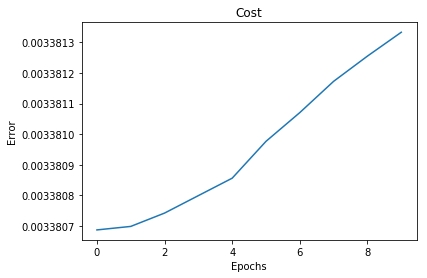

In [35]:
bootxgb.train(trainpredictions,Ytrain,valpredictions,Yval, optim = 'adam',lr = .00001)

In [77]:
np.sum(np.round(bootxgb.predict(trainpredictions,1))*Ytrain)/np.sum(Ytrain)

0.8645833333333334

In [39]:
bootxgb.predict(testpredictions, 1)

array([[9.84308298e-05],
       [1.00760348e-04],
       [1.07629576e-04],
       ...,
       [1.05798960e-04],
       [9.67365931e-05],
       [9.92152631e-05]])

In [41]:
np.sum(bootxgb.prediction*Ytest)/np.sum(Ytest)

0.8214285714285714

In [42]:
import sklearn

In [53]:
newpreds = bootxgb.probabilities
indices = np.argsort(newpreds, axis = 0).T[0]
predictions = newpreds[indices,]
truth = Ytest[indices,]

In [56]:
predictions

array([[4.17259568e-05],
       [4.65243801e-05],
       [5.16660148e-05],
       ...,
       [8.48718020e-01],
       [8.48803041e-01],
       [8.49695873e-01]])

In [63]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(truth.T[0], predictions.T[0])

In [65]:
sklearn.metrics.auc(fpr,tpr)

0.9805825283353702

# The below is the accuracy of the model. I guessed nearly 100% of the observations correctly.

In [73]:
np.sum(bootxgb.prediction==Ytest)/len(Ytest)

0.9994850307811147

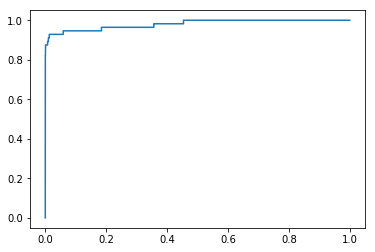

In [75]:
plt.plot(fpr,tpr)